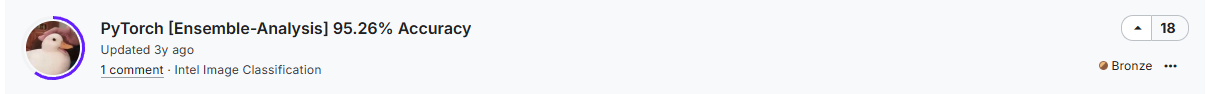

In [1]:
import torch
from torch import nn
import torchvision
import numpy as np
#!pip install timm
import timm
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torchvision.datasets import ImageFolder
import operator
import torchvision.transforms as transforms 
import seaborn as sns

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.ticker as ticker
import itertools

c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#test -> validation set
#pred -> test set (not labelled)
train_dir = "D:\code_study\ML_CODE\dataSets\IntelImageClassification\seg_train\seg_train"
test_dir = "D:\code_study\ML_CODE\dataSets\IntelImageClassification\seg_test\seg_test"
pred_dir = "D:\code_study\ML_CODE\dataSets\IntelImageClassification\seg_pred\seg_pred"

BATCH_SIZE = 64
EPOCHS = 9
CLASSES = os.listdir(train_dir)
metric = 0

In [3]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [4]:
def model_adjustment(p_model):
    for param in p_model.parameters():
        param.requires_grad=False
    return p_model

In [5]:
def model_assets(base_model, seed):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
    lrp_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    if seed == 0 or seed == 1:
        mls_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2], gamma=0.1)
        return criterion, optimizer, lrp_scheduler, mls_scheduler
    else:
        return criterion, optimizer, lrp_scheduler

In [6]:
def model_archive(seed):
    if seed == 0:
        model = torchvision.models.vgg19_bn(pretrained=True)
        model = model_adjustment(model)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=4096, out_features=len(CLASSES)),
        )
        model.to(device)
        criterion, optimizer, lrp_scheduler, mls_scheduler = model_assets(model, seed) 
        return model, criterion, optimizer, lrp_scheduler, mls_scheduler
    
    elif seed == 1:
        model = timm.create_model('vit_base_patch16_224', pretrained=True)
        model = model_adjustment(model)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler, mls_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler, mls_scheduler
    
    elif seed == 2:
        model = timm.create_model('ens_adv_inception_resnet_v2', pretrained=True)
        model = model_adjustment(model)
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler
    
    elif seed == 3:
        model = torchvision.models.densenet201(pretrained=True)
        model = model_adjustment(model)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler
    
    elif seed == 4:
        model = torchvision.models.resnext50_32x4d(pretrained=True)
        model = model_adjustment(model)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, out_features=len(CLASSES), bias=True)
        model.to(device)
        criterion, optimizer, lrp_scheduler = model_assets(model, seed)
        return model, criterion, optimizer, lrp_scheduler

In [8]:
# VGG19 with batch-normalization
model_vgg, criterion_vgg, optimizer_vgg, lrp_scheduler_vgg, mls_scheduler_vgg = model_archive(seed = 0)

# ViT (Vision Transformer)
model_vit, criterion_vit, optimizer_vit, lrp_scheduler_vit, mls_scheduler_vit = model_archive(seed = 1)

# Ensemble Adversarial Inception-ResNet v2
model_eairv, criterion_eairv, optimizer_eairv, lrp_scheduler_eairv = model_archive(seed = 2)

# DenseNet201 classifier
model_dn, criterion_dn, optimizer_dn, lrp_scheduler_dn = model_archive(seed = 3)

# ResNeXt50_32 Classifier
model_rnx, criterion_rnx, optimizer_rnx, lrp_scheduler_rnx = model_archive(seed = 4)

LocalEntryNotFoundError: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache. Please check your connection and try again or make sure your Internet connection is on.

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
transform_train_v1 = torchvision.transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.functional.InterpolationMode('bicubic'), max_size=None, antialias=None),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), std=([0.2290, 0.2240, 0.2250])),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), inplace=False),
    transforms.RandomApply([AddGaussianNoise(0., 0.156)], p=0.5),
])
transform_test_v1 = torchvision.transforms.Compose([
    transforms.Resize(size=256, interpolation=transforms.functional.InterpolationMode('bicubic'), max_size=None, antialias=None),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), std=([0.2290, 0.2240, 0.2250])),
])

In [ ]:
config_vit = resolve_data_config({}, model = model_vit)
transform_vit = create_transform(**config_vit)

config_eairv = resolve_data_config({}, model = model_eairv)
transform_eairv = create_transform(**config_eairv)

In [ ]:
train_data_v1 = ImageFolder(train_dir, transform = transform_train_v1)
test_data_v1 = ImageFolder(test_dir, transform = transform_test_v1)
#loading data for VGG19 BatchNorm, DenseNet201, ResNeXt50
train_loader_v1 = torch.utils.data.DataLoader(train_data_v1, BATCH_SIZE, shuffle=True)
test_loader_v1 = torch.utils.data.DataLoader(test_data_v1, BATCH_SIZE, shuffle=False)


train_data_vit = ImageFolder(train_dir, transform = transform_vit)
test_data_vit = ImageFolder(test_dir, transform = transform_vit)
#loading data for ViT
train_loader_vit = torch.utils.data.DataLoader(train_data_vit, BATCH_SIZE, shuffle=True)
test_loader_vit = torch.utils.data.DataLoader(test_data_vit, BATCH_SIZE, shuffle=False)


train_data_eairv = ImageFolder(train_dir, transform = transform_eairv)
test_data_eairv = ImageFolder(test_dir, transform = transform_eairv)
#loading data for Ensemble Adversarial Inception-ResNetV2
train_loader_eairv = torch.utils.data.DataLoader(train_data_eairv, BATCH_SIZE, shuffle=True)
test_loader_eairv = torch.utils.data.DataLoader(test_data_eairv, BATCH_SIZE, shuffle=False)

In [ ]:
def predictions_df(dl_model, test_loader, transform_obj):
    pred_hard, pred_soft = [], []
    correct_count, all_count = 0,0
    dl_model.eval()
    im_dim = transform_obj.transforms[1].size[0]
    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            for i in range(len(labels)):
                img = images[i].view(1, 3, im_dim, im_dim)
                # soft voting
                output = dl_model(img)
                sm = nn.Softmax(dim=1)
                probabilities = sm(output)
                prob_arr = (probabilities.detach().cpu().numpy())[0]
                # hard voting
                logps = dl_model(img)
                ps = torch.exp(logps)
                probab = list(ps.cpu()[0])
                pred_label = probab.index(max(probab))
                true_label = labels.cpu()[i]
                #exporting to dataframe
                pred_hard.append(pred_label)
                pred_soft.append(prob_arr)
                ####
                if(true_label == pred_label):
                    correct_count += 1
                all_count += 1

    print("Number of images Tested=", all_count)
    print("Model Accuracy=",(correct_count/all_count)*100)
    print("\n")
    return pred_hard, pred_soft

In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs, seed, model_name, lrp_scheduler, mls_scheduler=None):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        t0 = datetime.now()
        model.train()
        train_loss = []
        train_total = 0
        train_correct = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            _, train_predict = torch.max(outputs.data, 1)
            loss = criterion(outputs, targets)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_total += targets.size(0)
            train_correct += (train_predict == targets).sum().item()

        else:
            model.eval()
            test_loss = []
            test_total = 0
            test_correct = 0
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, test_predict = torch.max(outputs.data, 1)
                loss = criterion(outputs, targets)
                test_loss.append(loss.item())
                test_total += targets.size(0)
                test_correct += (test_predict == targets).sum().item()
            #get train and test loss
            test_loss = np.mean(test_loss)
            train_loss = np.mean(train_loss)
            #scheduler ReduceLROnPlateau and MultiStepLR
            lrp_scheduler.step(metric)
            if seed == 0 or seed == 1:
                mls_scheduler.step()
            ###    
            print('learning_rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))
            # Save losses
            train_losses[it] = train_loss
            test_losses[it] = test_loss

            dt = datetime.now() - t0
            print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Acc: {(100*train_correct/train_total):.4f}, \
                    Test Loss: {test_loss:.4f}, Test Acc: {(100*test_correct/test_total):.4f}, Duration: {dt}')
    return train_losses, test_losses

In [ ]:
print('Model: VGG-19-BN')
loss_train_vgg, loss_test_vgg = batch_gd(model_vgg, criterion_vgg, optimizer_vgg, train_loader_v1, test_loader_v1, EPOCHS, 0, 'vgg_dict.pth', lrp_scheduler_vgg, mls_scheduler_vgg)
print('\nModel: DenseNet201')
loss_train_dn, loss_test_dn = batch_gd(model_dn, criterion_dn, optimizer_dn, train_loader_v1, test_loader_v1, EPOCHS, 2, 'dn_dict.pth', lrp_scheduler_dn)
print('\nModel: ResNeXt50')
loss_train_rnx, loss_test_rnx = batch_gd(model_rnx, criterion_rnx, optimizer_rnx, train_loader_v1, test_loader_v1, EPOCHS, 4, 'rnx_dict.pth', lrp_scheduler_rnx)

In [ ]:
print('\nModel: Vision Transformer - ViT')
loss_train_vit, loss_test_vit = batch_gd(model_vit, criterion_vit, optimizer_vit, train_loader_vit, test_loader_vit, EPOCHS, 1, 'vit_dict.pth', lrp_scheduler_vit, mls_scheduler_vit)

In [ ]:
print('\nModel: Ensemble Adverserial Inception-Resnet-V2')
loss_train_eairv, loss_test_eairv = batch_gd(model_eairv, criterion_eairv, optimizer_eairv, train_loader_eairv, test_loader_eairv, EPOCHS, 3, 'eairv_dict.pth', lrp_scheduler_eairv)

In [ ]:
#predictions for each model (pred_hard, pred_soft)
vgg19_bn_hard, vgg19_bn_soft = predictions_df(model_vgg, test_loader_v1, transform_test_v1)
vit_hard, vit_soft = predictions_df(model_vit, test_loader_vit, transform_vit)
densenet201_hard, densenet201_soft = predictions_df(model_dn, test_loader_v1, transform_test_v1)
ensemble_adv_incres_v2_hard, ensemble_adv_incres_v2_soft = predictions_df(model_eairv, test_loader_eairv, transform_eairv)
resnext50_hard, resnext50_soft = predictions_df(model_rnx, test_loader_v1, transform_test_v1)
true_labels = []
#getting true labels
for _, labels in test_loader_v1:
    for x in range(len(labels)):
        true_labels.append(labels[x].item())

In [ ]:
def plot_model_accuracies():
    scores = []
    model_acc = {'vgg19BN':vgg19_bn_hard, 'ViT':vit_hard, 'DenseNet201':densenet201_hard,
                 'EAInceptionResNetV2':ensemble_adv_incres_v2_hard, 'ResNeXt50':resnext50_hard}
    for model_pred in model_acc.values():
        scores.append((accuracy_score(true_labels, model_pred))*100)
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(12,6)})
    ax = sns.barplot(y=list(model_acc.keys()), x=scores, palette="Blues_d", orient='h')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plot_model_accuracies()

In [ ]:
def plot_multi_model_losses():
    model_acc = {'vgg19BN':[loss_train_vgg, loss_test_vgg], 'ViT':[loss_train_vit, loss_test_vit],
                 'DenseNet201':[loss_train_dn, loss_test_dn], 'EAInceptionResNetV2':[loss_train_eairv, loss_test_eairv],
                 'ResNeXt50':[loss_train_rnx, loss_test_rnx]}
    sns.set()
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training and Testing losses')
    idx = 0
    for x in range(2):
        for y in range(3):
            if idx < 5:
                sns.lineplot(ax=axes[x, y], x=range(1,10), y=model_acc[list(model_acc.keys())[idx]][0])
                sns.lineplot(ax=axes[x, y], x=range(1,10),
                             y=model_acc[list(model_acc.keys())[idx]][1]).set_title(list(model_acc.keys())[idx])
            idx += 1
    fig.delaxes(ax = axes[1,2])
            
            
plot_multi_model_losses()

In [ ]:
def plot_confusion_matrix(preds, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    #getting the standard confusion matrix in text form
    cm = confusion_matrix(np.asarray(true_labels), np.asarray(preds))
    #using the matrix generated as means to plot a confusion matrix graphically
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(vgg19_bn_hard, CLASSES)

In [ ]:
plot_confusion_matrix(vit_hard, CLASSES)

In [ ]:
plot_confusion_matrix(densenet201_hard, CLASSES)

In [ ]:
plot_confusion_matrix(ensemble_adv_incres_v2_hard, CLASSES)

In [ ]:
plot_confusion_matrix(resnext50_hard, CLASSES)

In [ ]:
df_hard_voting = pd.DataFrame.from_dict({'vgg19_bn':vgg19_bn_hard, 'vit':vit_hard,
                    'densenet201':densenet201_hard, 'en_adv_incresv2':ensemble_adv_incres_v2_hard,
                    'resnext50':resnext50_hard})

In [ ]:
df_soft_voting = pd.DataFrame.from_dict({'vgg19_bn_soft':vgg19_bn_soft, 'vit_soft':vit_soft,
                    'densenet201_soft':densenet201_soft, 'en_adv_incresv2_soft':ensemble_adv_incres_v2_soft,
                    'resnext50_soft':resnext50_soft})

In [ ]:
ensemble_hard_predictions = np.asarray(df_hard_voting.mode(axis=1)[0])
ensemble_hard_score = accuracy_score(np.asarray(true_labels), ensemble_hard_predictions)
print(f"The Accuracy Score of Hard Voting Ensemble is:  {(ensemble_hard_score*100):.4f} %")

In [ ]:
plot_confusion_matrix(ensemble_hard_predictions, CLASSES, cmap=plt.cm.RdPu)

In [ ]:
def get_soft_voting():
    preds = []
    for x in range(len(df_soft_voting)):
        sample = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        for y in range(len(df_soft_voting.columns)):
            sample = tuple(map(operator.add, sample, (tuple(df_soft_voting.iloc[x,y]))))
        sample = tuple(ti/len(sample) for ti in sample)
        element = max(sample)
        idx = sample.index(element)
        preds.append(idx)
    return preds

ensemble_soft_preds = get_soft_voting()
ensemble_soft_score = accuracy_score(np.asarray(true_labels), np.asarray(ensemble_soft_preds))
print(f"The Accuracy Score of Hard Voting Ensemble is:  {(ensemble_soft_score*100):.4f} %")

In [ ]:
plot_confusion_matrix(ensemble_soft_preds, CLASSES, cmap=plt.cm.RdPu)

In [ ]:
def get_weighted_average():
    preds = []
    weights = [0.2315, 0.973, 0.221, 0.189, 0.123]
    for x in range(len(df_soft_voting)):
        sample = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        for y in range(len(df_soft_voting.columns)):
            ##
            k = tuple(float(weights[y]) * element for element in (tuple(df_soft_voting.iloc[x,y])))
            ##
            sample = tuple(map(operator.add, sample, k))
        sample = tuple(ti/len(sample) for ti in sample)
        element = max(sample)
        idx = sample.index(element)
        preds.append(idx)
    return preds

weighted_soft_preds = get_weighted_average()
weighted_soft_score = accuracy_score(np.asarray(true_labels), np.asarray(weighted_soft_preds))
print(f"The Accuracy Score of Hard Voting Ensemble is:  {(weighted_soft_score*100):.4f} %")

In [ ]:
plot_confusion_matrix(weighted_soft_preds, CLASSES, cmap=plt.cm.RdPu)

In [ ]:
def plot_final_accuracies():
    scores = []
    model_acc = {'vgg19BN':vgg19_bn_hard, 'ViT':vit_hard, 'DenseNet201':densenet201_hard,
                 'EAInceptionResNetV2':ensemble_adv_incres_v2_hard, 'ResNeXt50':resnext50_hard,
                 'ensemble-HV':ensemble_hard_predictions, 'ensemble-SV':ensemble_soft_preds,
                 'ensemble-WSV':weighted_soft_preds}
    for model_pred in model_acc.values():
        scores.append((accuracy_score(true_labels, model_pred))*100)
    sns.set_theme(style="whitegrid")
    sns.set(rc={'figure.figsize':(14,7)})
    ax = sns.barplot(y=list(model_acc.keys()), x=scores, palette="magma", orient='h')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plot_final_accuracies()